### Import

In [1]:
import sys
import time
import pickle
import gzip
from scipy import special
import scipy.ndimage
from scipy.sparse import csc_matrix, issparse
import numpy as np
import datetime as dt
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import csv
import math
import seaborn as sns

#import collections
#import sys
#import json
#from random import randint
#from scipy import misc

### Initial Settings

In [2]:
DATA_PATH = 'data/mnist/'

IMAGES_TRAIN = 'data_training'
IMAGES_TEST = 'data_testing'

RANDOM_SEED = 42
N_CLASSES = 10
N_FEATURES = 28 * 28

In [3]:
data_training = DATA_PATH+IMAGES_TRAIN
data_testing = DATA_PATH+IMAGES_TEST
ft = gzip.open(data_training, 'rb')
TRAINING = pickle.load(ft)
ft.close()
ft = gzip.open(data_testing, 'rb')
TESTING = pickle.load(ft)
ft.close()

## Clustering - K-Means

In [4]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return idx

def build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED,init_size=3*cluster)
    kmeans.fit(np.hstack(weights).reshape(-1,1))
    return kmeans.cluster_centers_

In [5]:
def redefine_weights(weights,centers):
    arr_ret = np.empty_like(weights).astype(np.int16)
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            arr_ret[i,j] = nearest_centroid_index(centers,weights[i,j])
    return arr_ret

def idx_matrix_to_matrix(idx_matrix,centers,shape):
    return centers[idx_matrix.reshape(-1,1)].reshape(shape)

def centroid_gradient_matrix(idx_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_matrix,index=range(cluster))

## PRUNING - CSC Matrix

In [6]:
def pruning_matrix(mat,percentage,method='out'):
    threshold = (100-percentage)
    
    if method == 'inout':
        threshold /= 4
        perc_up,perc_down,perc_mid_up,perc_mid_down = 100 - threshold, threshold, 50 + threshold, 50 - threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        percentile_mid_up = np.percentile(mat,perc_mid_up)
        percentile_mid_down = np.percentile(mat,perc_mid_down)
    else:
        threshold /= 2
        if method == 'in': perc_up, perc_down = 50 + threshold, 50 - threshold
        elif method == 'out': perc_up, perc_down = 100 - threshold, threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        
    w_pruned = np.copy(mat)
    for i,row in enumerate(mat):
        for j,_ in enumerate(row):
            if method == 'in':
                if mat[i,j] > percentile_down and mat[i,j] < percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'out':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'inout':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up or (mat[i,j] > percentile_mid_down and mat[i,j] < percentile_mid_up):
                    w_pruned[i,j] = 0
    return w_pruned

# in place
def sparse_sub_dense(sparse,dense,mask):
    sparse.data -= dense.T[mask.T]
    
def delete_last_row(csc):
    i = csc.indptr[-1]
    indptr = csc.indptr[:-1]
    data = csc.data[:i]
    indices = csc.indices[:i]
    return csc_matrix((data,indices,indptr))

## PRUNING and CLUSTERING 

In [7]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return idx

def build_clusters_pruning(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED,init_size=3*cluster)
    kmeans.fit(weights.data.reshape(-1,1))
    return kmeans.cluster_centers_

def redefine_weights_pruning(weights,centers):
    new_data_idx = [nearest_centroid_index(centers,w) for w in weights.data]
    return csc_matrix((new_data_idx,weights.indices,weights.indptr))

def idx_matrix_to_matrix_pruning(idx_matrix,centers):
    return csc_matrix((centers[idx_matrix.data].reshape(-1,),idx_matrix.indices,idx_matrix.indptr))

def centroid_gradient_pruning(idx_matrix,gradient,mask,cluster):
    gradient += 0.000000001
    gradient[mask] = 0
    return scipy.ndimage.sum(csc_matrix(gradient).data,idx_matrix.data,index=range(cluster))

# MODULAR NEURAL NETWORK

In [8]:
class Neural_Network:
    
    ''' SETTING METHOD '''
    
    def __init__(self, neurons, batchsize):
        self.state = 'base'
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        self.step = 10
        # Standardize random weights
        np.random.seed(RANDOM_SEED)
        hidden_layer = np.random.rand(self.neurons, self.input_size + 1) / self.neurons
        output_layer = np.random.rand(self.output_size, self.neurons + 1) / self.output_size
        self.layers = [hidden_layer, output_layer]
        
    def setPruning(self,weights,percentage,method):
        self.state = 'pruning'
        self.pruning = percentage
        # Pruning weights
        pw_hidden = csc_matrix(pruning_matrix(weights[0],percentage,method))
        pw_output = csc_matrix(pruning_matrix(weights[1],percentage,method))
        self.pruned_layers = [pw_hidden, pw_output]
        # Matrix mask
        mask_hidden = pw_hidden.A != 0 
        mask_output = pw_output.A != 0
        self.masks = [mask_hidden,mask_output]
        
    def setClustering(self,weights,cluster):
        self.masks,self.layers_shape,self.centers,self.idx_layers = [],[],[],[]
        self.cluster = cluster
        if issparse(weights[0]) and issparse(weights[1]):
            self.state = 'clustering_pruned'
            # Matrix mask
            mask_hidden = weights[0].A == 0 
            mask_output = weights[-1].A == 0
            self.masks = [mask_hidden,mask_output]
            # Variable for shape
            shape_hidden = (self.neurons,self.input_size+1)
            shape_output = (self.output_size,self.neurons+1)
            self.layers_shape = [shape_hidden,shape_output]
            # Initialize cluster for pre-trained weights (dict with centers)
            c_hidden = build_clusters_pruning(cluster,weights[0])
            c_output = build_clusters_pruning(cluster,weights[-1])
            self.centers = [c_hidden,c_output]
            # Initialize index matrix for pre-trained weights
            idx_hidden = redefine_weights_pruning(weights[0],self.centers[0])
            idx_output = redefine_weights_pruning(weights[-1],self.centers[-1])
            self.idx_layers = [idx_hidden,idx_output]
        else :
            self.state = 'clustering'
            # Variable for shape
            shape_hidden = (self.neurons,self.input_size+1)
            shape_output = (self.output_size,self.neurons+1)
            self.layers_shape = [shape_hidden,shape_output]  
            # Initialize cluster for pre-trained weights (dict with centers)
            c_hidden = build_clusters(cluster,weights[0])
            c_output = build_clusters(cluster,weights[1])
            self.centers = [c_hidden,c_output]
            # Initialize index matrix for pre-trained weights
            idx_hidden = redefine_weights(weights[0],self.centers[0])
            idx_output = redefine_weights(weights[1],self.centers[1])
            self.idx_layers = [idx_hidden,idx_output]
        
    def setStopFunction(self,stop_function,stop_parameter):
        self.stop_f = stop_function
        self.stop_p = stop_parameter
    
    def setPrintOptions(self,step,file_output=None):
        self.step = step
        self.file = file_output
        
    ''' TRAINING '''    

    def train(self, training, testing):
        
        self.best,self.same,self.iteration,accu_train = 0.,0,0,[0.,0.]
        
        ''' Batch Setting '''
        len_batch_train = len(training[0])
        len_batch_test = len(testing[0])
        if(self.batchsize > 0 and self.batchsize <= 1):
            len_batch_train = int(np.ceil(len_batch_train * self.batchsize))
            len_batch_test = int(np.ceil(len_batch_test * self.batchsize))     
        # Divide training and testing batches
        test_output = testing[0:len_batch_test][0:len_batch_test]
        test_input = training[0:len_batch_train][0:len_batch_train]
        inputs = training[0][0:len_batch_train]
        targets = np.zeros((len_batch_train, 10))
        for i in range(len_batch_train):
            targets[i, training[1][i]] = 1
            
        # Start prints 
        self.start_time = dt.datetime.now()
        print(self.whichNN(self.state))
        print('-- Training Session Start (%s) --' % (self.start_time))
        print('\nBatch Train: %d (%d%%)\nBatch Test: %d (%d%%)\nNeurons: %d' % (len_batch_train,self.batchsize*100,len_batch_test,self.batchsize*100,self.neurons))
        if self.state == 'pruning': print('Pruning: %d%%' % self.pruning)
        elif self.state == 'clustering' or self.state == 'clustering_pruned': print('Clusters: %d' % self.cluster)
        print('%s\n' % self.stringStopFunction(self.stop_f,self.stop_p))
        
        
        ''' Train Begin '''
        
        if self.state == 'base':
            # Performs iterations
            while not self.is_stop_function_enabled(accu_train[1]):
                self.iteration += 1
                for input_vector, target_vector in zip(inputs, targets):
                    self.backpropagate_base(input_vector, target_vector)
                # Accuracy
                accu_test = self.accu(test_output)
                accu_train = self.accu(test_input)
                # Messages
                if (self.iteration == 1 or self.iteration % self.step == 0):
                    self.print_message_iter(self.iteration,accu_test,accu_train,self.ETAepoch(self.start_time)) 
                    
        elif self.state == 'pruning':
            # Performs iterations
            while not self.is_stop_function_enabled(accu_train[1]):
                self.iteration += 1
                for input_vector, target_vector in zip(inputs, targets):
                    self.backpropagate_pruning(input_vector, target_vector)
                # Accuracy
                accu_test = self.accu(test_output)
                accu_train = self.accu(test_input)
                # Messages
                if (self.iteration == 1 or self.iteration % self.step == 0):
                    self.print_message_iter(self.iteration,accu_test,accu_train,self.ETAepoch(self.start_time))
                    
        elif self.state == 'clustering':
             # Performs iterations
            while not self.is_stop_function_enabled(accu_train[1]):
                self.iteration += 1
                for input_vector, target_vector in zip(inputs, targets):
                    weights = []
                    for i,c,s in zip(self.idx_layers,self.centers,self.layers_shape):
                        w = idx_matrix_to_matrix(i,c,s)
                        weights.append(w)
                    self.backpropagate_clustering(input_vector, target_vector, weights)
                # Accuracy
                accu_test = self.accu_clustering(test_output,weights)
                accu_train = self.accu_clustering(test_input,weights)
                # Messages
                if (self.iteration == 1 or self.iteration % self.step == 0):
                    self.print_message_iter(self.iteration,accu_test,accu_train,self.ETAepoch(self.start_time))
        
        elif self.state == 'clustering_pruned':
            # Performs iterations
            while not self.is_stop_function_enabled(accu_train[1]):
                self.iteration += 1
                # Backpropagate with feed forward
                for input_vector, target_vector in zip(inputs, targets):
                    weights = []
                    for i,c in zip(self.idx_layers,self.centers):
                        w = idx_matrix_to_matrix_pruning(i,c)
                        weights.append(w)
                    self.backpropagate_clustering_pruned(input_vector, target_vector, weights)
                # Accuracy
                accu_test = self.accu_clustering_pruned(test_output,weights)
                accu_train = self.accu_clustering_pruned(test_input,weights)
                # Messages
                if (self.iteration == 1 or self.iteration % self.step == 0):
                    self.print_message_iter(self.iteration,accu_test,accu_train,self.ETAepoch(self.start_time))
        
        # Print last epoch
        if (self.iteration % self.step != 0):
            self.print_message_iter(self.iteration,accu_test,accu_train,self.ETAepoch(self.start_time))
        # Final message
        print('\n-- Training Session End (%s) --\n' % (dt.datetime.now()))
        # File outout
        if self.file:
            with open(self.file, "a") as file_output:
                if self.state == 'base': file_output.write(self.csvLine(self.neurons,None,None,self.ETAepoch(self.start_time),accu_train,accu_test))
                elif self.state == 'pruning': file_output.write(self.csvLine(self.neurons,None,self.pruning,self.ETAepoch(self.start_time),accu_train,accu_test))
                elif self.state == 'clustering': file_output.write(self.csvLine(self.neurons,self.cluster,None,self.ETAepoch(self.start_time),accu_train,accu_test))
                elif self.state == 'clustering_pruned': file_output.write(self.csvLine(self.neurons,self.cluster,self.pruning,self.ETAepoch(self.start_time),accu_train,accu_test))
                file_output.write('\n')
    
    
    ''' Feed Forward '''    
        
    def feed_forward_base(self, input_vector):
        outputs = []
        for layer in self.layers:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(layer, input_with_bias)
            output = special.expit(output)
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs
        
    def feed_forward_pruning(self, input_vector):
        outputs = []
        for layer in self.pruned_layers:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = layer * input_with_bias
            output = special.expit(output)
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def feed_forward_clustering(self, input_vector, weights):
        outputs = []
        for w in weights:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(w, input_with_bias)
            output = special.expit(output) # Sigmoid function
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs
    
    def feed_forward_clustering_pruned(self, input_vector, weights):
        outputs = []
        for w in weights:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = w * input_with_bias
            output = special.expit(output)
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs
    
    ''' Backpropagate '''    
        
    def backpropagate_base(self, input_vector, target):
        c = 10**(-4) + 10**(-1)/math.sqrt(self.iteration)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward_base(input_vector)
        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        self.layers[-1] -= c*np.outer(output_deltas, np.append(hidden_outputs, 1))
        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * np.dot(np.delete(self.layers[-1], self.neurons, 1).T, output_deltas)
        self.layers[0] -= c*np.outer(hidden_deltas, np.append(input_vector, 1))
        
    def backpropagate_pruning(self, input_vector, target):
        c = 10**(-4) + (10**(-1))/math.sqrt(self.iteration)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward_pruning(input_vector)
        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        sparse_sub_dense(self.pruned_layers[-1],c*np.outer(output_deltas, np.append(hidden_outputs, 1)),self.masks[-1])
        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * (delete_last_row(self.pruned_layers[-1]).T * output_deltas)
        sparse_sub_dense(self.pruned_layers[0],c*np.outer(hidden_deltas, np.append(input_vector, 1)),self.masks[0])
        
    def backpropagate_clustering(self, input_vector, target, weights):
        c = 10**(-4) + (10**(-1))/math.sqrt(self.iteration)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward_clustering(input_vector, weights)
        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        gradient = np.outer(output_deltas, np.append(hidden_outputs, 1))
        cg = centroid_gradient_matrix(self.idx_layers[-1],gradient,self.cluster)
        self.centers[-1] = self.centers[-1] - c * np.array(cg).reshape(self.cluster,1)
        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * np.dot(np.delete(weights[-1], self.neurons, 1).T, output_deltas)
        gradient = np.outer(hidden_deltas, np.append(input_vector, 1))
        cg = centroid_gradient_matrix(self.idx_layers[0],gradient,self.cluster)
        self.centers[0] = self.centers[0] - c * np.array(cg).reshape(self.cluster,1)
        
    def backpropagate_clustering_pruned(self, input_vector, target, weights):
        c = 10**(-4) + (10**(-1))/math.sqrt(self.iteration)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward_clustering_pruned(input_vector, weights)
        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        gradient = np.outer(output_deltas, np.append(hidden_outputs, 1))
        cg = centroid_gradient_pruning(self.idx_layers[-1],gradient,self.masks[-1],self.cluster)
        self.centers[-1] = self.centers[-1] - (c * np.array(cg)).reshape(-1,1)
        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * (delete_last_row(weights[-1]).T * output_deltas)
        gradient = np.outer(hidden_deltas, np.append(input_vector, 1))
        cg = centroid_gradient_pruning(self.idx_layers[0],gradient,self.masks[0],self.cluster)
        self.centers[0] = self.centers[0] - (c * np.array(cg)).reshape(-1,1)
  
    ''' Prediction '''

    def predict_one(self, input_vector):
        if self.state == 'base': return np.argmax(self.feed_forward_base(input_vector)[-1])
        elif self.state == 'pruning': return np.argmax(self.feed_forward_pruning(input_vector)[-1])
    
    def predict_one_clustering(self, input_vector, weights):
        if self.state == 'clustering': return np.argmax(self.feed_forward_clustering(input_vector,weights)[-1])
        elif self.state == 'clustering_pruned': return np.argmax(self.feed_forward_clustering_pruned(input_vector,weights)[-1])
    
    ''' Accuracy '''
        
    def accu(self, testing_batch):
        res = np.zeros((10, 2))
        for k in range(len(testing_batch[1])):
            if self.predict_one(testing_batch[0][k]) == testing_batch[1][k]:
                res[testing_batch[1][k]] += 1
            else:
                res[testing_batch[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    def accu_clustering(self, testing, weights):
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one_clustering(testing[0][k], weights) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    def accu_clustering_pruned(self, testing, weights):
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one_clustering(testing[0][k], weights) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    ''' Helper Functions '''
    
    def is_stop_function_enabled(self,accuracy):
        if self.stop_f == 0:
            if self.iteration < self.stop_p:
                return False
            else:
                return True
        elif self.stop_f == 1:
            if accuracy > self.best or self.iteration == 0:
                self.same = 0
                self.best = accuracy
                return False
            else:
                self.same += 1
                if self.same < self.stop_p:
                    return False
                else:
                    return True
        elif self.stop_f == 2:
            if accuracy > self.best + self.stop_p or self.iteration == 0:
                self.best = accuracy
                return False
            else:
                return True
    
    def print_message_iter(self,iteration,accu_test,accu_train,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Accuracy TRAIN: '+str(accu_train[1]).zfill(4)+'%\t'
        message += 'Accuracy TEST: '+str(accu_test[1]).zfill(4)+'%\t'
        message += 'Min: '+ str(accu_test[0]).zfill(4)+ '% ('+str(int(accu_test[2]))+')'
        print(message)
    
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret
    
    def stringStopFunction(self,stop_function,stop_parameter):
        typeTrainingPrint = "Stop Function: "    
        if stop_function == 0:
            typeTrainingPrint += str(stop_parameter)+" epochs"
        elif stop_function == 1:
            typeTrainingPrint += str(stop_parameter)+" epoch(s) w/o improvements"
        elif stop_function == 2:
            typeTrainingPrint += "improvements below "+str(stop_parameter)+"%"
        return typeTrainingPrint
    
    def whichNN(self,state):
        if state == 'base': return '# NEURAL NETWORK #'
        elif state == 'pruning': return '# NEURAL NETWORK -- Pruning #'
        elif state == 'clustering' or state == 'clustering_pruned': return '# NEURAL NETWORK -- Clustering #'
        
    def csvLine(self,neurons,cluster,pruning,time,a_train,a_test):
        if cluster and pruning:
            cr = round((N_FEATURES*neurons)*64/(N_FEATURES*neurons*(pruning/100)*math.log(cluster,2) + cluster*64),2)
            return str(pruning/100)+','+str(cluster)+','+str(cr)+','+time+','+str(a_train[1])+','+str(a_test[1])          
        elif cluster: 
            cr = round((N_FEATURES*neurons)*64/((N_FEATURES*neurons)*math.log(cluster,2) + cluster*64),2)
            return str(cluster)+','+str(cr)+','+time+','+str(a_train[1])+','+str(a_test[1])
        elif pruning:
            cr = round((N_FEATURES*neurons)/(N_FEATURES*neurons*(pruning/100)),2)
            return str(pruning/100)+','+str(cr)+','+time+','+str(a_train[1])+','+str(a_test[1])
        else:
            return str(neurons)+','+time+','+str(a_train[1])+','+str(a_test[1])
     
    ''' Weights Matrix '''
    
    def getWeights(self):
        return self.layers
    
    def getPrunedWeights(self):
        return self.pruned_layers
    
    def getClusteredWeights(self):
        return self.idx_layers,self.centers

In [9]:
nn = Neural_Network(neurons=70,batchsize=1)
nn.setStopFunction(2,0.01)
nn.setPrintOptions(10)
nn.train(TRAINING,TESTING)

trained_weights = nn.getWeights()
nn.setClustering(trained_weights,128)
nn.setPrintOptions(3)
nn.train(TRAINING,TESTING)

nn.setPruning(trained_weights,70,'in')
nn.setPrintOptions(3)
nn.train(TRAINING,TESTING)

pruned_weights = nn.getPrunedWeights()
nn.setClustering(pruned_weights,64)
nn.setPrintOptions(3)
nn.train(TRAINING,TESTING)

# NEURAL NETWORK #
-- Training Session Start (2019-02-10 19:43:35.814361) --

Batch Train: 60000 (100%)
Batch Test: 10000 (100%)
Neurons: 70
Stop Function: improvements below 0.01%

Epoch 001 (18s)    Accuracy TRAIN: 93.16%	Accuracy TEST: 93.21%	Min: 87.89% (5)
Epoch 010 (2m46s)  Accuracy TRAIN: 97.74%	Accuracy TEST: 96.88%	Min: 95.34% (9)
Epoch 020 (5m30s)  Accuracy TRAIN: 98.38%	Accuracy TEST: 97.38%	Min: 96.4% (7)
Epoch 030 (8m15s)  Accuracy TRAIN: 98.66%	Accuracy TEST: 97.52%	Min: 96.3% (7)
Epoch 036 (9m54s)  Accuracy TRAIN: 98.78%	Accuracy TEST: 97.57%	Min: 96.33% (9)

-- Training Session End (2019-02-10 19:53:30.054992) --

# NEURAL NETWORK -- Clustering #
-- Training Session Start (2019-02-10 19:53:31.057983) --

Batch Train: 60000 (100%)
Batch Test: 10000 (100%)
Neurons: 70
Clusters: 128
Stop Function: improvements below 0.01%

Epoch 001 (53s)    Accuracy TRAIN: 98.67%	Accuracy TEST: 97.29%	Min: 96.04% (9)
Epoch 003 (2m39s)  Accuracy TRAIN: 98.71%	Accuracy TEST: 97.36%	Min: 96.

# RESULT

In [10]:
def read_csv(file_name):
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        header = next(csv_reader, None)
        data = np.array([[t for t in row] for row in csv_reader])
        return header,data.T

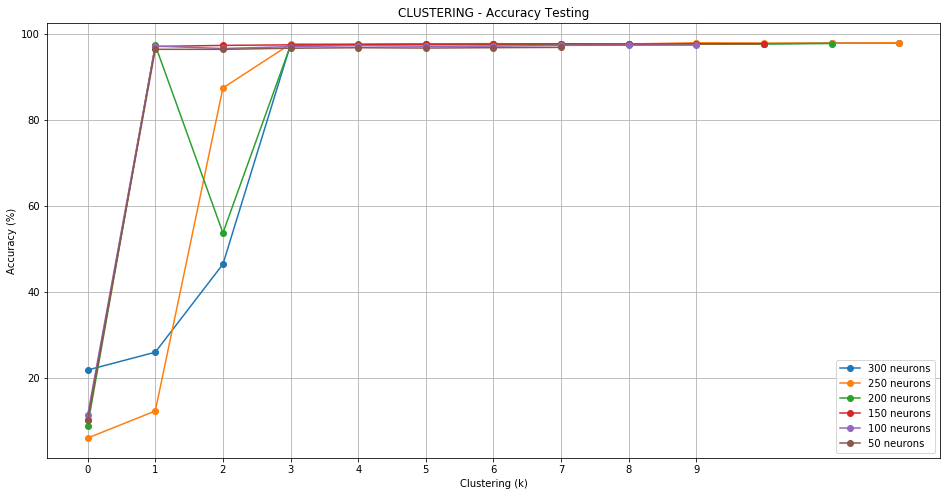

In [11]:
plt.figure(figsize=(16,8))
plt.title('CLUSTERING - Accuracy Testing')
for i in range(300,10,-50):
    p = read_csv('experiments/csv/clustering/'+str(i)+'_neurons.csv')
    x,y = np.arange(len(p[1][0])),np.array(p[1][4],dtype=float)
    plt.plot(x,y,marker='o',label=str(i)+' neurons')
plt.xticks(np.arange(10))
plt.xlabel('Clustering (k)')
plt.ylabel('Accuracy (%)')
plt.legend()
#ax = plt.gca()
#ax.set_xticklabels(np.array([96,128,192,256,384,512,768,1024,1536,2048],dtype=int))
plt.grid()
#plt.savefig('Clustering_Compression_Rate.png', dpi=400)
plt.show()

In [12]:
def heatmap(n,pr,cl,acc,vmin,annot,save):
    clusters = np.sort(np.unique(np.array(cl,dtype='int')))
    d,l = dict(),dict()
    for i,(j,k) in enumerate(zip(pr,cl)): d[(float(j),int(k))] = i
    for i in range(90,0,-10):
        for j in clusters:
            if (i/100,j) in d.keys():
                l[((i/100,j))] = float(acc[d[(i/100,j)]])
            else:
                l[(i/100,j)] = 0
    data = np.array([x for x in l.values()]).reshape(9,len(clusters))
    mask = data == 0
    fig, ax = plt.subplots(figsize=(12,12))
    
    sns_plot = sns.heatmap(data, mask=mask,
                    vmin=vmin,
                    yticklabels=np.array(range(90,0,-10))/100,
                    xticklabels=clusters,
                    annot=annot, square=True, robust=True,
                    cmap='Reds',ax=ax, fmt='.2f',
                    cbar_kws={'label': 'Accuracy (%)'})
    figure = sns_plot.get_figure()
    ax.set_ylabel('Pruning')    
    ax.set_xlabel('Clustering (k)')
    ax.set_title('Accuracy Testing - '+str(n)+' Neurons',fontsize=16)
    if save: figure.savefig(str(n)+"_neurons.png", dpi=400)

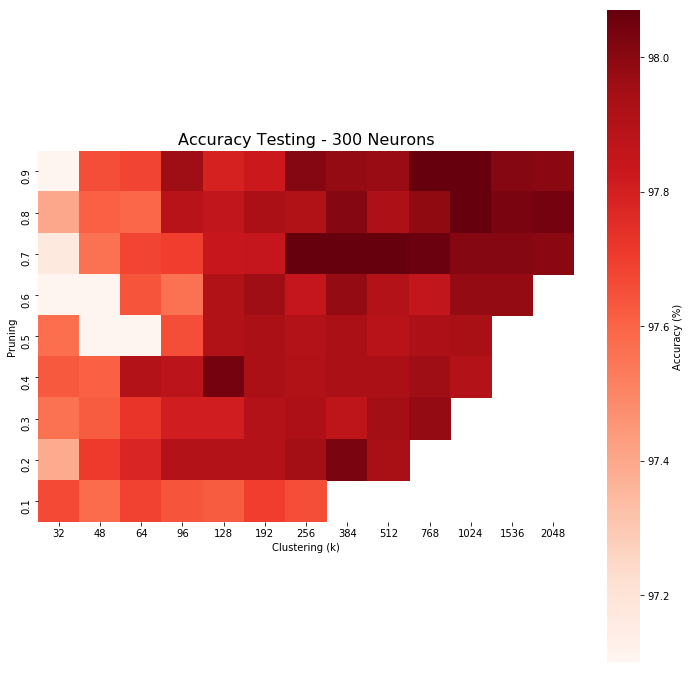

In [13]:
i = 300
pc = read_csv('experiments/csv/pruning_clustering/'+str(i)+'_neurons.csv')
pr = pc[1][0]
cl = pc[1][1]
acc = pc[1][5]
heatmap(i,pr,cl,acc,97.1,False,True)